In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import cwt,icwt,Wavelet,ssq_cwt,issq_cwt
from ssqueezepy.experimental import scale_to_freq
import obspy
import sys
from scipy.optimize import curve_fit
from vmdpy import VMD
machine_epsilon = sys.float_info.epsilon

In [ ]:
def gauss1(x, a1, b1, c1):
    return a1 * np.exp(-((x - b1)**2) / (2 * c1**2))



def cal_pp1(W):
    WW_abs=np.abs(W)
    WW_abs=WW_abs+np.mean(WW_abs)
    xu=np.linspace(0,W.shape[0]-1,W.shape[0])
    # xu=np.linspace(1,W.shape[0],W.shape[0])
    pp=np.zeros(W.shape[0])
    for i in range(W.shape[0]):
        # W_abs=W_abs+np.mean(W_abs)
        prob_dist = WW_abs[i, :] / (np.sum(WW_abs[i, :]) + 1e-8)
        pp[i] = -np.sum(prob_dist * np.log(prob_dist + 1e-8))
    pp=1-(pp-np.min(pp))/(np.max(pp)-np.min(pp))

    xData = np.ravel(xu)
    yData = np.ravel(pp)
    mm = np.max(yData)   
    nn_index = np.argmax(yData)       
    b1_guess = xData[nn_index]        
    c1_guess = (np.max(xData) - b1_guess) / 3  
    initial_guess = [mm, b1_guess, c1_guess]
    param_bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(gauss1, xData, yData, p0=initial_guess, bounds=param_bounds,maxfev=5000) 

    a1_fit, b1_fit, c1_fit = popt
    st1 = max(int(np.ceil(b1_fit - 3*c1_fit)), 0)
    ed1 = min(int(np.floor(b1_fit + 3*c1_fit)), W.shape[0]-1)
    return st1,ed1

def para_free_denoising_v5zhao(data, org_tf, f,  nrs, f_s, f_e):

    id = len(data)
    noise_rov = np.zeros(id)
    start_s = int(np.floor(id / nrs))
    end_s = start_s
    for i in range(start_s, id - end_s):
        var_front = np.var(data[0:i+1])  
        var_back = np.var(data[i:])     
        if var_back != 0:
            noise_rov[i] = var_front / var_back
        else:
            noise_rov[i] = np.inf
    search_range = noise_rov[start_s:id-end_s]
    if len(search_range) > 0:
        noise_t_rel = np.argmin(search_range)
        noise_tt = noise_t_rel + start_s + 1  
    else:
        noise_tt = start_s + 1
    fi1 = np.argmin(np.abs(f_s - f))
    fi2 = np.argmin(np.abs(f_e - f))
    f_x = np.zeros_like(org_tf)
    thre = np.zeros(org_tf.shape[0])
    
    for i in range(fi1, fi2 + 1):  
        wk = org_tf[i, :]
        noise_wk = np.abs(wk[0:noise_tt])
        mad_val = np.mean(np.abs(noise_wk - np.mean(noise_wk)))
        thre1 = np.sqrt(2 * np.log(noise_tt)) * mad_val / 0.67
        mask = noise_wk >= thre1
        if np.any(mask):
            thre_a = np.mean(noise_wk[mask])
        else:
            thre_a = thre1
        thre_b = np.max(np.abs(wk))
        interval = [thre_a, thre_b]
        _, gcv_thre = fibonacci_v2(wk, interval)
        f_x[i, :] = thresh(wk, gcv_thre)
        thre[i] = gcv_thre
    # for kk in range(1):
    #     f_x = pixe_pro(f_x, bwconn)
    return f_x

def thresh(y, t):

    res = np.abs(y) - t
    x = (np.sign(res) + 1) * y / 2
    return x


def fibonacci_v2(y, interval):

    a, b = interval[0], interval[1]
    F = [1, 1]
    n = 2
    while n < 20:
        F.append(F[n-1] + F[n-2])
        n += 1
    n = len(F) - 1
    x1 = a + (F[n-2] / F[n]) * (b - a)
    x2 = a + (F[n-1] / F[n]) * (b - a)
    f1 = gcv(y, x1)
    f2 = gcv(y, x2)
    k = 0
    while n > 3:
        k += 1
        n -= 1
        
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            if n >= 1:
                x2 = a + (F[n-1] / F[n]) * (b - a)
                f2 = gcv(y, x2)
        elif f1 == f2:
            a = x1
            b = x2
            if n >= 2:
                x1 = a + (F[n-2] / F[n]) * (b - a)
                x2 = a + (F[n-1] / F[n]) * (b - a)
                f1 = gcv(y, x1)
                f2 = gcv(y, x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            if n >= 2:
                x1 = a + (F[n-2] / F[n]) * (b - a)
                f1 = gcv(y, x1)
    x = (a + b) / 2
    return k, x

def gcv(j, t):
    N = len(j)
    res = np.abs(j) - t
    N0 = np.sum(res <= 0)  
    y = np.sign(j) * res * (res >= 0)
    if N0 == 0:
        gcv_val = 0
    else:
        gcv_val = N * (np.linalg.norm(y - j) / N0) ** 2
    return gcv_val



In [ ]:


def new_method(W,st1,ed1):
    W1=W[st1+1:ed1].copy()
    W4=W1.copy()
    W1_abs=np.abs(W1)
    I=W1_abs.sum(axis=0)
    I_min=np.min(I)
    I_max=np.max(I)
    I_norm=(I - I_min) / (I_max - I_min+machine_epsilon)
    I_1=W1_abs.copy()
    for i in range(W1.shape[0]):
        I_norm_1=I_norm.copy()
        W2_abs_f=W1_abs[i,:]
        W2_abs_f_min=np.min(W2_abs_f)
        W2_abs_f_max=np.max(W2_abs_f)
        W2_norm_f=(W2_abs_f - W2_abs_f_min) / (W2_abs_f_max - W2_abs_f_min+machine_epsilon)
        mask=I_norm_1>W2_norm_f
        I_norm_1[mask]=W2_norm_f[mask]
        I_1[i,:]=I_norm_1*(I_max - I_min)+I_min
    W3=W1/(I_1+machine_epsilon)
    W3_abs=np.abs(W3)
    #-------------------------------------------------------------------
    nu=100
    curve=np.zeros((nu))
    nnn=np.linspace(np.min(I_1), np.max(I_1),nu)
    ik=0
    for i in nnn:
        # curve[ik]=np.sum(np.abs(I_W1-i*I_W3))
        curve[ik]=np.sum(np.abs(W1_abs-i*W3_abs))
        if ik > 0:
            if curve[ik] > curve[ik - 1]:  
                break
        ik=ik+1
    #-------------------------------------------------------------------
    curve1=np.zeros((nu))
    if ik-2>0:
        nnn1=np.linspace(nnn[ik-2], nnn[ik],nu)
    else:
        nnn1=np.linspace(0, nnn[ik],nu)
    # nnn1=np.linspace(nnn[np.max([ik-2,0])], nnn[ik],nu)
    # nnn1=np.linspace(nnn[ik-2], nnn[ik],nu)
    ik1=0
    for i in nnn1:
        # curve[ik]=np.sum(np.abs(I_W1-i*I_W3))
        curve1[ik1]=np.sum(np.abs(W1_abs-i*W3_abs))
        if ik1 > 0:
            if curve1[ik1] > curve1[ik1 - 1]:  
                break
        ik1=ik1+1
    if ik-1>0:
        k=nnn1[ik1-1]
    else:
        k=0
    # k=nnn1[np.max([ik1-1,0])]
    # k=nnn1[ik1-1]
    #-------------------------------------------------------------------
    W3_k=W3*k
    W3_kabs=np.abs(W3_k)
    for i in range(W1.shape[0]):
        mask = W3_kabs[i,:]>W1_abs[i,:]
        W3_k[i,mask]=W1[i,mask]
    W4=W1-W3_k        
    W4_abs=np.abs(W4)
    W4=W4*np.max(I-I_min)/np.max(W4_abs.sum(axis=0))
    W4_4=W.copy()
    W4_4[:st1+1,:]=0
    W4_4[ed1:,:]=0
    W4_4[st1+1:ed1]=W4
    return W4_4








def hard_thre(W,Lamda):
    W_hard=W.copy()
    W_hard_abs=np.abs(W_hard)
    for i in range(W_hard_abs.shape[0]):
        nn = W_hard_abs[i, :] < Lamda[i]  
        W_hard[i, nn] = 0  
    return W_hard



def soft_thre(W,Lamda):
    W_soft=W.copy()
    W_soft_abs=np.abs(W_soft)
    for i in range(W_soft.shape[0]):
        W_soft_abs[i, :]  = np.maximum(0, W_soft_abs[i, :]  - Lamda[i])
    W_soft=W_soft/np.abs(W_soft)*W_soft_abs
    return W_soft


def jingyi_thre(W,Lamda,alpha):
    WW_soft_new=W.copy()
    WW_soft_new_abs=np.abs(WW_soft_new)
    for i in range(WW_soft_new.shape[0]):
        nn = WW_soft_new_abs[i, :] >= Lamda[i]  
        WW_soft_new_abs[i, nn]  =  WW_soft_new_abs[i, nn]  - Lamda[i]/(np.exp(3*alpha*(WW_soft_new_abs[i, nn] -Lamda[i])/Lamda[i]))
        nn = WW_soft_new_abs[i, :] < Lamda[i]  
        WW_soft_new_abs[i, nn]=0
    WW=WW_soft_new_abs*WW_soft_new/np.abs(WW_soft_new)
    return WW
 



def li_thre(W,Lamda,alpha,beta):
    WW_soft_new1=W.copy()
    WW_soft_new1_abs=np.abs(WW_soft_new1)
    for i in range(WW_soft_new1_abs.shape[0]):
        nn = WW_soft_new1_abs[i, :] >= Lamda[i]  
        # WW_soft_new1_abs[i, nn]  = np.sign(WW_soft_new1_abs[i, nn] ) * np.maximum(0, WW_soft_new1_abs[i, nn]  - Lamda[i]/(alpha*(WW_soft_new1_abs[i, nn]  - Lamda[i])**beta+1))
        WW_soft_new1_abs[i, nn]  = WW_soft_new1_abs[i, nn] -Lamda[i]/(alpha*(WW_soft_new1_abs[i, nn]-Lamda[i])**beta+1)
       
        nn = WW_soft_new1_abs[i, :] < Lamda[i]  
        WW_soft_new1_abs[i, nn]=0
    WW=WW_soft_new1_abs* WW_soft_new1/np.abs(WW_soft_new1)
    return WW
 



def zhang_thre(W,Lamda,A):
    WW_soft_new1=W.copy()
    WW_soft_new1_abs=np.abs(WW_soft_new1)
    for i in range(WW_soft_new1_abs.shape[0]):
        nn = WW_soft_new1_abs[i, :] >= Lamda[i]  
        WW_soft_new1_abs[i, nn]  = WW_soft_new1_abs[i, nn] -Lamda[i]*(A/np.max(WW_soft_new1_abs[i, :]))**(1/2)
        nn = WW_soft_new1_abs[i, :] < Lamda[i]  
        WW_soft_new1_abs[i, nn]=0
    WW=WW_soft_new1_abs* WW_soft_new1/np.abs(WW_soft_new1)
    return WW



def cal_thre(W_abs):
    N=W_abs.shape[1]
    Lamda=np.zeros(W_abs.shape[0])
    for i in range(W_abs.shape[0]):
        Lamda[i]=np.median(W_abs[i,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(i+1+1)
    return Lamda



In [ ]:
st = obspy.read("Pertusillo_real_data1.mseed")
fs = st[0].stats.sampling_rate
xu=list(range(len(st)))
yla=[]
#------------------------------------------------------------------
W_result = np.zeros((6, len(xu), 3500))  

for ikk in range(len(xu)):  
    nkk = xu[ikk]  
    s=st[nkk].data[4500:8000]
    s=s-np.mean(s)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    nv = 10
    wavelet = Wavelet(wavelet='morlet')
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    # freq = scale_to_freq(scales, wavelet, len(s), fs=fs)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Lamda=cal_thre(W_abs)
    #Adaptive--------------------------------------------------
    W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
    w_zhang=icwt(W_zhang,wavelet=wavelet, nv=nv)
    #jing-yi-------------------------------------------------
    alpha=.1
    W_jingyi=jingyi_thre(W,Lamda,alpha)
    w_jingyi=icwt(W_jingyi,wavelet=wavelet, nv=nv)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VMD
    N=len(s)
    K = 5          
    alpha = 1000    
    tau = 0         
    DC = 0          
    init = 2        
    tol = 1e-7      
    WVMD, u_hat, omega = VMD(s, alpha, tau, K, DC, init, tol)
    for j in range(WVMD.shape[0]):
        WVMD0,scales= cwt(WVMD[j,:], wavelet=wavelet,nv=nv)
        W_absVMD=np.abs(WVMD0)
        LamdaVMD=np.zeros(W_absVMD.shape[0])
        for ii in range(W_absVMD.shape[0]):
            LamdaVMD[ii]=np.median(W_absVMD[ii,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(ii+1+1)
        W_softVMD=soft_thre(WVMD0,LamdaVMD)
        WVMD[j,:]=icwt(W_softVMD,wavelet=wavelet, nv=nv)
    w_soft=np.sum(WVMD,axis=0)
    #gcv-----------------------------------------------------
    org_tf, freqs, Wx, scales,= ssq_cwt(s, wavelet,nv=nv)
    f = scale_to_freq(scales, wavelet, len(s), fs=fs)
    f=f[::-1]
    pixel_dw = para_free_denoising_v5zhao(s,org_tf,f,8,20,0,fs)
    w_gcv=issq_cwt(pixel_dw,wavelet=wavelet)
    #------------------------------------------------------------------
    # New Method-------------------------------------------------------
    st1,ed1=cal_pp1(W)
    W4=new_method(W,st1,ed1)
    # w1=icwt(W4,wavelet=wavelet, nv=nv)
    Xii=np.zeros(W.shape)
    mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
    Xii[mask]=1
    W4=Xii*W4
    w1=icwt(W4,wavelet=wavelet, nv=nv)



    W_result[0, ikk, :] = s
    W_result[1, ikk, :] = w_soft
    W_result[2, ikk, :] = w_jingyi
    W_result[3, ikk, :] = w_zhang
    W_result[4, ikk, :] = w_gcv
    W_result[5, ikk, :] = w1


    yla.append(st[nkk].stats.station)

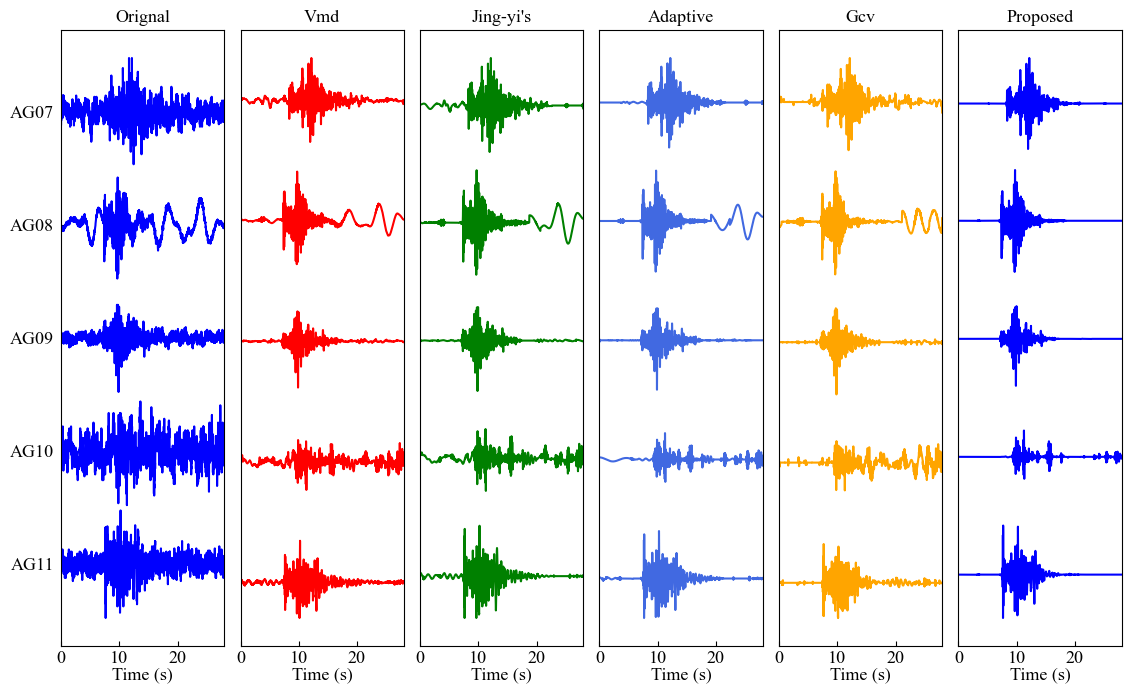

In [ ]:
ln=1
NN=13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN  
plt.rcParams['ytick.labelsize'] = NN  
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in' 


color=['b','r','g','#4169E1','#FFA500','b','g']
tit=['Orignal','Vmd',"Jing-yi's",'Adaptive','Gcv','Proposed']
t = np.arange(0, len(s)) / fs  
fig = plt.figure(figsize=(16, 8))
# fig, axs = plt.subplots(1, 10, figsize=(21, 4))

plt.subplots_adjust(wspace=0.1)  

# fig = plt.figure(figsize=(21, 4))
for j in range(W_result.shape[0]):
    plt.subplot(1, 7, j+1)  
    plt.title(tit[j])
    iii=0
    for i in range(W_result.shape[1]):  
        iii=iii+1

        mi=np.min(np.abs(W_result[0,i, :]))
        ma=np.max(np.abs(W_result[0,i, :]))
        s1=W_result[j,i, :]
        normalized_s = (s1-mi) / (ma-mi)  
        shifted_signal = normalized_s - iii*2.1        
        plt.yticks([])
        plt.plot(t, shifted_signal,color[j])  
        plt.xlim(t[0],t[-1])
        plt.xlabel('Time (s)')



    if j == 0:
        n_signals = W_result.shape[1]
        tick_positions = [-2.1 * (i+1) for i in range(n_signals)]
        plt.yticks(ticks=tick_positions, labels=yla, fontsize=NN) 
        plt.tick_params(axis='y', which='major', pad=5) 

# plt.savefig("fig10.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [ ]:
st = obspy.read("Bogdanka_real_data2.mseed")
fs = st[0].stats.sampling_rate
xu=list(range(len(st)))
yla=[]
#------------------------------------------------------------------
W_result = np.zeros((6, len(xu), 5000))  

for ikk in range(len(xu)):  
    nkk = xu[ikk]  
    s=st[nkk].data[0:5000]
    s=s-np.mean(s)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    nv = 10
    wavelet = Wavelet(wavelet='morlet')
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    # freq = scale_to_freq(scales, wavelet, len(s), fs=fs)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Lamda=cal_thre(W_abs)
    #Adaptive--------------------------------------------------
    W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
    w_zhang=icwt(W_zhang,wavelet=wavelet, nv=nv)
    #jing-yi-------------------------------------------------
    alpha=.1
    W_jingyi=jingyi_thre(W,Lamda,alpha)
    w_jingyi=icwt(W_jingyi,wavelet=wavelet, nv=nv)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VMD
    N=len(s)
    K = 5          
    alpha = 1000    
    tau = 0         
    DC = 0          
    init = 2       
    tol = 1e-7     
    # VMD 
    WVMD, u_hat, omega = VMD(s, alpha, tau, K, DC, init, tol)
    for j in range(WVMD.shape[0]):
        WVMD0,scales= cwt(WVMD[j,:], wavelet=wavelet,nv=nv)
        W_absVMD=np.abs(WVMD0)
        LamdaVMD=np.zeros(W_absVMD.shape[0])
        for ii in range(W_absVMD.shape[0]):
            LamdaVMD[ii]=np.median(W_absVMD[ii,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(ii+1+1)
        W_softVMD=soft_thre(WVMD0,LamdaVMD)
        WVMD[j,:]=icwt(W_softVMD,wavelet=wavelet, nv=nv)
    w_soft=np.sum(WVMD,axis=0)
    #gcv-----------------------------------------------------
    org_tf, freqs, Wx, scales,= ssq_cwt(s, wavelet,nv=nv)
    f = scale_to_freq(scales, wavelet, len(s), fs=fs)
    f=f[::-1]
    pixel_dw = para_free_denoising_v5zhao(s,org_tf,f,20,0,fs)
    w_gcv=issq_cwt(pixel_dw,wavelet=wavelet)
    #------------------------------------------------------------------
    # New Method-------------------------------------------------------
    st1,ed1=cal_pp1(W)
    W4=new_method(W,st1,ed1)
    # w1=icwt(W4,wavelet=wavelet, nv=nv)
    Xii=np.zeros(W.shape)
    mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
    Xii[mask]=1
    W4=Xii*W4
    w1=icwt(W4,wavelet=wavelet, nv=nv)



    W_result[0, ikk, :] = s
    W_result[1, ikk, :] = w_soft
    W_result[2, ikk, :] = w_jingyi
    W_result[3, ikk, :] = w_zhang
    W_result[4, ikk, :] = w_gcv
    W_result[5, ikk, :] = w1


    yla.append(st[nkk].stats.station)

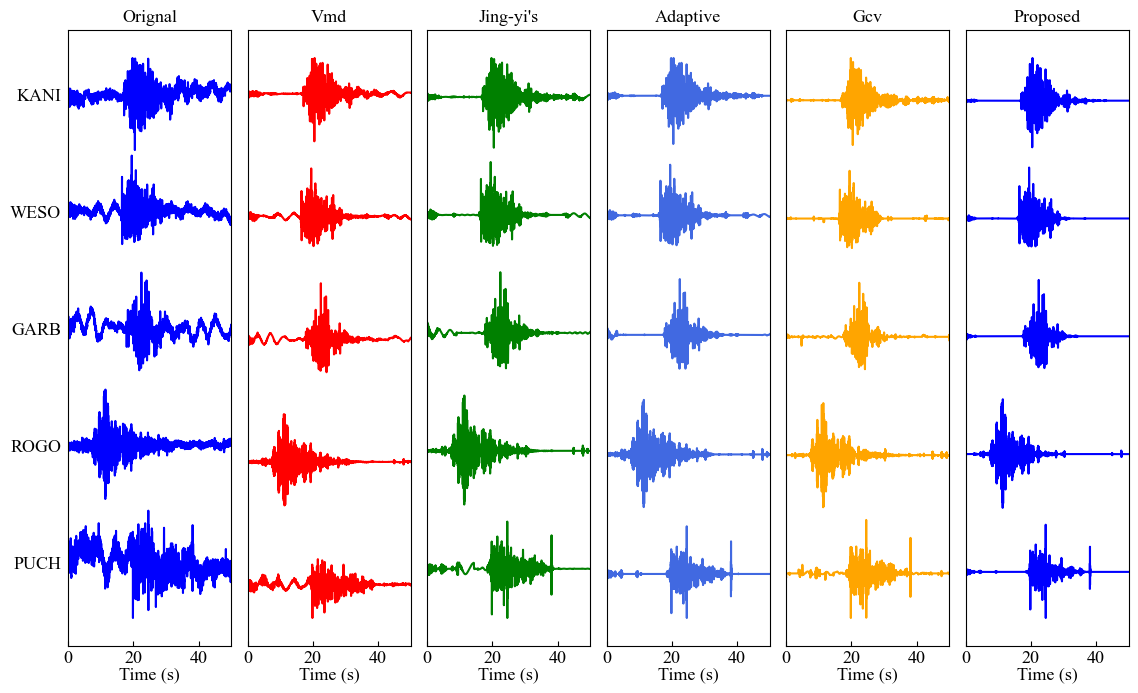

In [ ]:
ln=1
NN=13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN  
plt.rcParams['ytick.labelsize'] = NN 
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in' 


color=['b','r','g','#4169E1','#FFA500','b','g']
tit=['Orignal','Vmd',"Jing-yi's",'Adaptive','Gcv','Proposed']
t = np.arange(0, len(s)) / fs  
fig = plt.figure(figsize=(16, 8))
# fig, axs = plt.subplots(1, 10, figsize=(21, 4))

plt.subplots_adjust(wspace=0.1)  

# fig = plt.figure(figsize=(21, 4))
for j in range(W_result.shape[0]):
    plt.subplot(1, 7, j+1)  
    plt.title(tit[j])
    iii=0
    for i in range(W_result.shape[1]):  
        iii=iii+1

        mi=np.min(np.abs(W_result[0,i, :]))
        ma=np.max(np.abs(W_result[0,i, :]))
        s1=W_result[j,i, :]
        normalized_s = (s1-mi) / (ma-mi)  
        shifted_signal = normalized_s - iii*2.1         
        plt.yticks([])
        plt.plot(t, shifted_signal,color[j])  
        plt.xlim(t[0],t[-1])
        plt.xlabel('Time (s)')



    if j == 0:
        n_signals = W_result.shape[1]
        tick_positions = [-2.1 * (i+1) for i in range(n_signals)]
        plt.yticks(ticks=tick_positions, labels=yla, fontsize=NN) 
        plt.tick_params(axis='y', which='major', pad=5) 

# plt.savefig("fig11.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [ ]:
st = obspy.read("Oklahoma_real_data3.mseed")
fs = st[0].stats.sampling_rate
xu=list(range(len(st)))
#------------------------------------------------------------------
W_result = np.zeros((6, len(xu), 10000))  
yla=[]
for ikk in range(len(xu)):  
    nkk = xu[ikk]  
    sstt=st[nkk].data
    s=sstt[4000:14000]
    s=s-np.mean(s)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    nv = 10
    wavelet = Wavelet(wavelet='morlet')
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    # freq = scale_to_freq(scales, wavelet, len(s), fs=fs)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Lamda=cal_thre(W_abs)
    #Adaptive--------------------------------------------------
    W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
    w_zhang=icwt(W_zhang,wavelet=wavelet, nv=nv)
    #小波阈值-jing-yi-------------------------------------------------
    alpha=.1
    W_jingyi=jingyi_thre(W,Lamda,alpha)
    w_jingyi=icwt(W_jingyi,wavelet=wavelet, nv=nv)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VMD
    N=len(s)
    K = 5          
    alpha = 1000    
    tau = 0         
    DC = 0          
    init = 2        
    tol = 1e-7      
    # VMD 
    WVMD, u_hat, omega = VMD(s, alpha, tau, K, DC, init, tol)
    for j in range(WVMD.shape[0]):
        WVMD0,scales= cwt(WVMD[j,:], wavelet=wavelet,nv=nv)
        W_absVMD=np.abs(WVMD0)
        LamdaVMD=np.zeros(W_absVMD.shape[0])
        for ii in range(W_absVMD.shape[0]):
            LamdaVMD[ii]=np.median(W_absVMD[ii,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(ii+1+1)
        W_softVMD=soft_thre(WVMD0,LamdaVMD)
        WVMD[j,:]=icwt(W_softVMD,wavelet=wavelet, nv=nv)
    w_soft=np.sum(WVMD,axis=0)
    #gcv_liantong-----------------------------------------------------
    org_tf, freqs, Wx, scales,= ssq_cwt(s, wavelet,nv=nv)
    f = scale_to_freq(scales, wavelet, len(s), fs=fs)
    f=f[::-1]
    pixel_dw = para_free_denoising_v5zhao(s,org_tf,f,8,20,0,fs)
    w_gcv=issq_cwt(pixel_dw,wavelet=wavelet)
    #------------------------------------------------------------------
    # New Method-------------------------------------------------------
    st1,ed1=cal_pp1(W)
    W4=new_method(W,st1,ed1)
    # w1=icwt(W4,wavelet=wavelet, nv=nv)
    Xii=np.zeros(W.shape)
    mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
    Xii[mask]=1
    W4=Xii*W4
    w1=icwt(W4,wavelet=wavelet, nv=nv)



    W_result[0, ikk, :] = s
    W_result[1, ikk, :] = w_soft
    W_result[2, ikk, :] = w_jingyi
    W_result[3, ikk, :] = w_zhang
    W_result[4, ikk, :] = w_gcv
    W_result[5, ikk, :] = w1


    yla.append(st[nkk].stats.station)

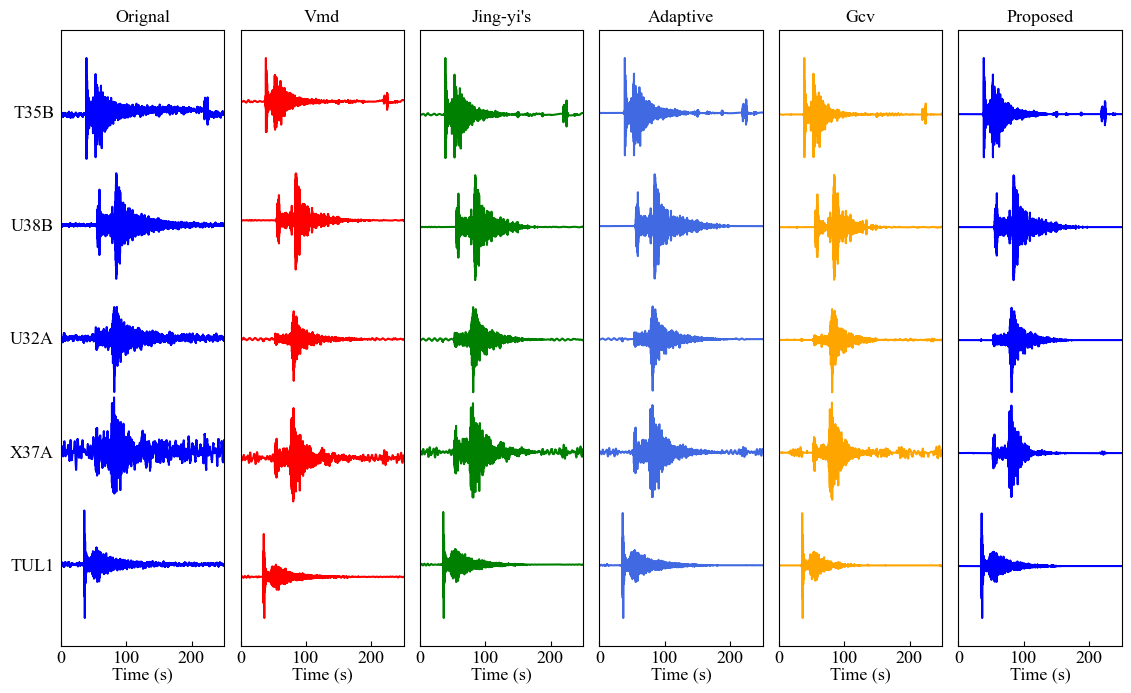

In [ ]:
ln=1
NN=13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN  
plt.rcParams['ytick.labelsize'] = NN  
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'  


color=['b','r','g','#4169E1','#FFA500','b','g']
tit=['Orignal','Vmd',"Jing-yi's",'Adaptive','Gcv','Proposed']



t = np.arange(0, len(s)) / fs  
fig = plt.figure(figsize=(16, 8))
# fig, axs = plt.subplots(1, 10, figsize=(21, 4))

plt.subplots_adjust(wspace=0.1)  

# fig = plt.figure(figsize=(21, 4))
for j in range(W_result.shape[0]):
    plt.subplot(1, 7, j+1)  
    plt.title(tit[j])
    iii=0
    for i in range(W_result.shape[1]):  
        iii=iii+1

        mi=np.min(np.abs(W_result[0,i, :]))
        ma=np.max(np.abs(W_result[0,i, :]))
        s1=W_result[j,i, :]
        normalized_s = (s1-mi) / (ma-mi)  
        shifted_signal = normalized_s - iii*2.1        
        plt.yticks([])
        plt.plot(t, shifted_signal,color[j])  
        plt.xlim(t[0],t[-1])
        plt.xlabel('Time (s)')



    if j == 0:
        n_signals = W_result.shape[1]
        tick_positions = [-2.1 * (i+1) for i in range(n_signals)]
        plt.yticks(ticks=tick_positions, labels=yla, fontsize=NN) 
        plt.tick_params(axis='y', which='major', pad=5) 

# plt.savefig("fig12.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()